# PollenCounter
Gradient-Effected Object Recognition Gauge for hive Entrances (GEORGE)

## Imports

In [1]:
import os
import pathlib
#from pathlib import Path

# Clone the tensorflow models repository if it doesn't already exist
# if "models" in pathlib.Path.cwd().parts:
#     while "models" in pathlib.Path.cwd().parts:
#         os.chdir('..')
# elif not pathlib.Path('models').exists():
#     !git clone --depth 1 https://github.com/tensorflow/models

import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import imutils
import cv2
import scipy
#import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
from tqdm import tqdm
import time
import math

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

import pandas as pd
import sys

import skimage
import skimage.io
import skimage.transform
from skimage import io, transform
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from matplotlib import cm
import GEORGE_Library as GEORGE
%matplotlib inline

print("Done")

Done


## Define global variables

In [2]:
Yang_Model = 1
PollenDataset = 1
BeeAlarmed = 1

category_index = {1: {'id': 1, 'name': 'regular'}, 2: {'id': 2, 'name': 'cooling'}, 3: {'id': 3, 'name': 'pollen'}, 4: {'id': 4, 'name': 'varroa'}, 5: {'id': 5, 'name': 'wasps'}}
IMAGE_PATH = 'Yang Model Training/bee_imgs/bee_imgs/'
IMAGE_WIDTH = 75
IMAGE_HEIGHT = 150
IMAGE_CHANNELS = 3
CLIP_HIST_PERCENTAGE = 20
NUM_IMAGES = 20
EX_SUB = False
RANDOM_STATE = 2018
TEST_SIZE = 0.2
VAL_SIZE = 0.2
CONV_2D_DIM_1 = 16
CONV_2D_DIM_2 = 16
CONV_2D_DIM_3 = 32
CONV_2D_DIM_4 = 64
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 32
NO_EPOCHS_1 = 5
NO_EPOCHS_2 = 10
NO_EPOCHS_3 = 50
PATIENCE = 5
VERBOSE = 1

path="PollenDataset/images/"
imlist= glob.glob(os.path.join(path, '*.jpg'))

print("Done")

Done


## Load Datasets

image format is a uint8 numpy array with shape (img_height, img_width, 3)
label format is an array of four values, either 0 or 1 (e.g [0, 1, 0, 0] for pollen), where the first value corresponding to "regular" is omitted and corresponding to a category index:

category_index = {1: {'id': 1, 'name': 'regular'}, 2: {'id': 2, 'name': 'cooling'}, 3: {'id': 3, 'name': 'pollen'}, 4: {'id': 4, 'name': 'varroa'}, 5: {'id': 5, 'name': 'wasps'}}

### Yang Model

In [3]:
if Yang_Model:
    honey_bee_df = pd.read_csv('Yang Model Training/bee_data.csv')
    honey_bee_df = honey_bee_df.replace({'location':'Athens, Georgia, USA'}, 'Athens, GA, USA')

    train_df, val_df = train_test_split(honey_bee_df, test_size=VAL_SIZE, random_state=RANDOM_STATE, 
                                         stratify=honey_bee_df['health'])

    YM_img_train, YM_label_train = GEORGE.categories_encoder(train_df, var = 'health')
    _, YM_label_train_pollen = GEORGE.categories_encoder(train_df, var = 'pollen_carrying')
    YM_img_val, YM_label_val = GEORGE.categories_encoder(val_df)
    _, YM_label_val_pollen = GEORGE.categories_encoder(train_df, var = 'pollen_carrying')
    print("Training set: {}, Validation set: {}".format(len(list(YM_img_train)), len(list(YM_img_val))))
else:
    print("Done")

Training set: 4137, Validation set: 1035


### PollenDataset

In [10]:
if PollenDataset:
    PD_img, PD_label = GEORGE.PD_dataset(imlist)
    new_PD_label = []
    
    for i in range(len(PD_label)):
        if PD_label[i] == 0:
            new_PD_label.append([0, 0, 0, 0])
        elif PD_label[i] == 1:
            new_PD_label.append([0, 1, 0, 0])
        i = i + 1

    new_PD_img = []
    for image in PD_img:
        temp = cv2.resize(image * 255, dsize=(IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA)
        new_PD_img.append(np.array(temp).astype('uint8'))

    PD_img_train = new_PD_img[0:(round(len(new_PD_img) * 0.8))]
    PD_img_val = new_PD_img[(round(len(new_PD_img) * 0.8)):len(new_PD_img)]

    PD_label_train = new_PD_label[0:(round(len(new_PD_label) * 0.8))]
    PD_label_val = new_PD_label[(round(len(new_PD_label) * 0.8)):len(new_PD_label)]
    
    print("Training set: {}, Validation set: {}".format(len(list(PD_img_train)), len(list(PD_img_val))))
else:
    print("Done")

Training set: 571, Validation set: 143


### BeeAlarmed

In [5]:
if BeeAlarmed:
    (ds_train, ds_val), metadata = tfds.load("bee_dataset/bee_dataset_150",
                                             split=["train[0%:80%]", "train[80%:100%]"],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)
    BA_img_train = []
    BA_img_val = []
    BA_label_train = []
    BA_label_val = []
    
    for i in range(len(ds_train)):
        tmp_BA_img, tmp_BA_label = next(iter(ds_train))
        BA_img_train.append(np.array(tmp_BA_img).astype('uint8'))
        BA_label_train.append(np.array(tfds.as_numpy(tmp_BA_label.values())).astype('uint8'))
        i = i + 1
    for j in range(len(ds_val)):
        tmp_BA_img, tmp_BA_label = next(iter(ds_val))
        BA_img_val.append(np.array(tmp_BA_img).astype('uint8'))
        BA_label_val.append(np.array(tfds.as_numpy(tmp_BA_label.values())).astype('uint8'))
        j = j + 1

    print("Training set: {}, Validation set: {}".format(len(list(BA_img_train)), len(list(BA_img_val))))
else:
    print("Done")

Training set: 5992, Validation set: 1498


## Data Augmentation

Augment training images: 100%|█████████████████████████████████████████████████████| 20/20 [00:00<00:00, 23.13images/s]

Succeeded for 20 of 20



Augment val images: 100%|██████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 23.15images/s]

Succeeded for 20 of 20



Augment training images: 100%|█████████████████████████████████████████████████████| 20/20 [00:00<00:00, 23.29images/s]

Succeeded for 20 of 20



Augment val images: 100%|██████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 23.29images/s]

Succeeded for 20 of 20



Prep training images: 100%|██████████████████████████████████████████████████████| 40/40 [00:00<00:00, 1083.88images/s]

Succeeded for 40 of 40


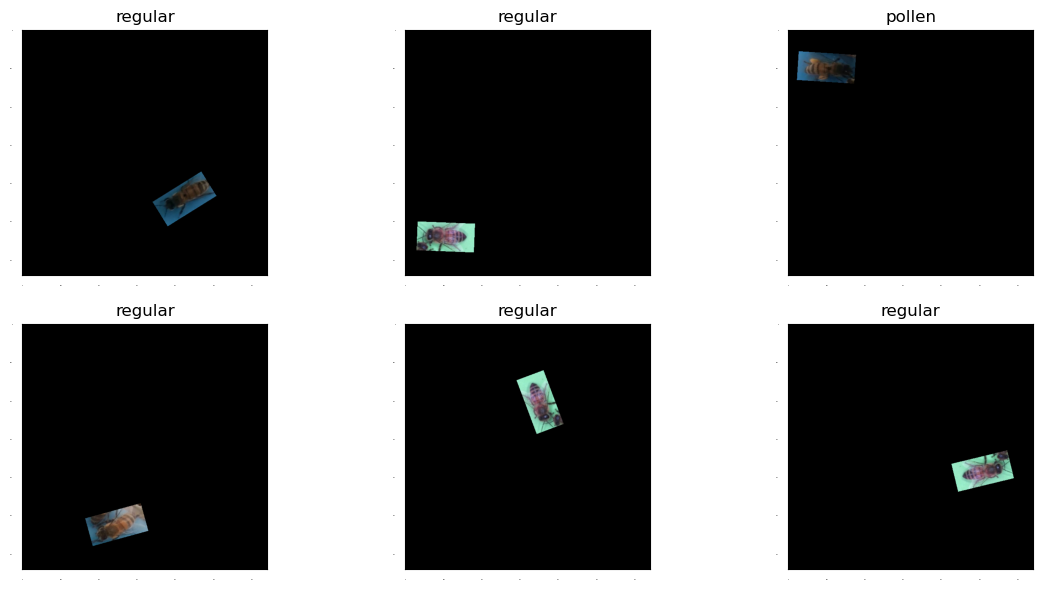

In [12]:
train_images_np = []
gt_boxes = []
train_labels = []
test_images_np = []

if BeeAlarmed:
    BA_train_images_np, BA_gt_boxes, BA_train_labels = GEORGE.augment_npset(BA_img_train, BA_label_train, num_images = NUM_IMAGES, set_name="Augment training images", ex_sub = EX_SUB)
    BA_test_images_np = GEORGE.augment_npset(BA_img_val, BA_label_val, training=False, num_images = NUM_IMAGES, set_name="Augment val images", ex_sub = EX_SUB)
    [train_images_np.append(i) for i in BA_train_images_np]
    [gt_boxes.append(i) for i in BA_gt_boxes]
    [train_labels.append(i) for i in BA_train_labels]
    [test_images_np.append(i) for i in BA_test_images_np]
    
if PollenDataset:    
    PD_train_images_np, PD_gt_boxes, PD_train_labels = GEORGE.augment_npset(PD_img_train, PD_label_train, num_images = NUM_IMAGES, set_name="Augment training images", ex_sub = EX_SUB)
    PD_test_images_np = GEORGE.augment_npset(PD_img_val, PD_label_val, training=False, num_images = NUM_IMAGES, set_name="Augment val images", ex_sub = EX_SUB)
    [train_images_np.append(i) for i in PD_train_images_np]
    [gt_boxes.append(i) for i in PD_gt_boxes]
    [train_labels.append(i) for i in PD_train_labels]
    [test_images_np.append(i) for i in PD_test_images_np]
    
if Yang_Model:    
    pass

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

enum_img_subset = []
enum_label_subset = []

for i in range(0, 6):
    rand_enum_val = random.randint(0, len(train_images_np) - 1)
    enum_img_subset.append(train_images_np[rand_enum_val])
    enum_label_subset.append(train_labels[rand_enum_val])

for idx, train_image_np in enumerate(enum_img_subset[0:6]):
    plt.subplot(2, 3, idx+1)
    plt.title((enum_label_subset[idx])[0]['name'])
    plt.imshow(train_image_np)
plt.show

# By convention, our non-background classes start counting at 1.
num_classes = 5

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
item_num = np.shape(train_images_np)[0]

with tqdm(total=np.shape(train_images_np)[0], unit="images", desc=str("Prep training images")) as pbar:
    for (train_image_np, gt_box_np, train_label) in zip(train_images_np, gt_boxes, train_labels):
        train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
        gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
        #zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
        gt_classes_one_hot_tensors.append([train_label[1]])
        pbar.update(1)
gt_classes_one_hot_tensors = np.array(gt_classes_one_hot_tensors)
print('Succeeded for ' + str(len(train_image_tensors)) + ' of ' + str(item_num), flush=True)

# Let's just visualize the images as a sanity check

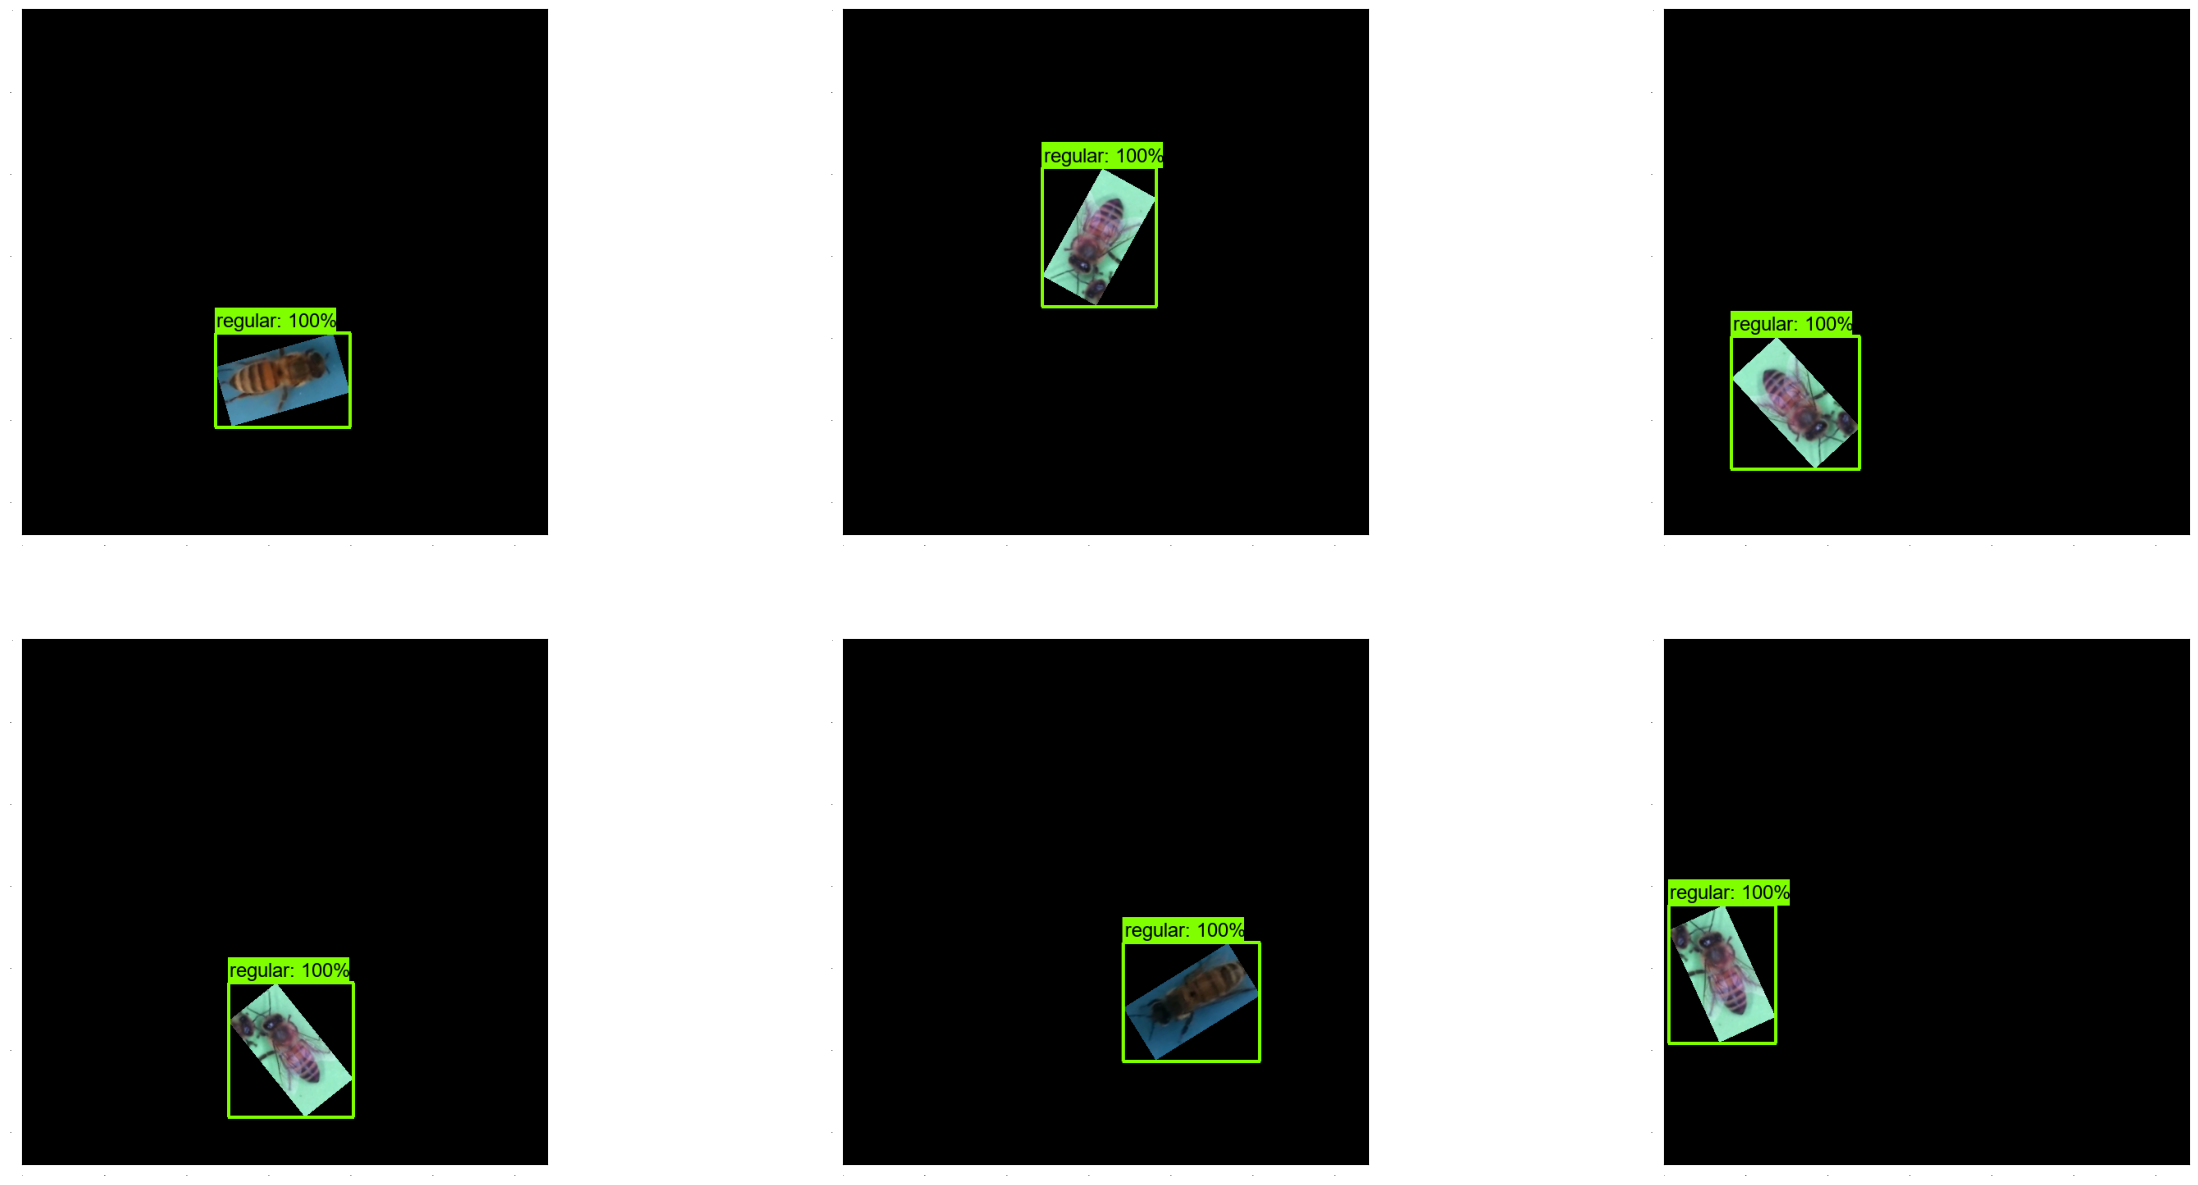

In [15]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(6):
    rand_elem = random.randint(0, len(train_image_tensors) - idx - 1)
    plt.subplot(2, 3, idx+1)
    GEORGE.plot_detections(
        train_images_np[idx + rand_elem],
        gt_boxes[idx + rand_elem],
        np.array(train_labels[idx + rand_elem][2]),
        dummy_scores,
        category_index)
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [6]:
retinapath = pathlib.Path('.').absolute() / "models" / "research" / "object_detection" / "test_data" / "checkpoint"

# Clone the tensorflow models repository if it doesn't already exist
if os.path.exists(retinapath):
    pass
elif not os.path.exists(retinapath):
    !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
    !tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
    #!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

print("Done")

Done


In [7]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 5
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [ ]:
detection_model.summary()

# Eager mode custom training loop



In [8]:
#tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 64
learning_rate = 0.01
num_batches = round(len(train_image_tensors) / batch_size) # AKA "Iterations"
epochs = 10

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    """Get a tf.function for training step."""

    # Use tf.function for a bit of speed.
    # Comment out the tf.function decorator if you want the inside of the
    # function to run eagerly.
    @tf.function
    def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
        """A single training iteration.

        Args:
          image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
            Note that the height and width can vary across images, as they are
            reshaped within this function to be 640x640.
          groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
            tf.float32 representing groundtruth boxes for each image in the batch.
          groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
            with type tf.float32 representing groundtruth boxes for each image in
            the batch.

        Returns:
          A scalar tensor representing the total loss for the input batch.
        """
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
                [detection_model.preprocess(image_tensor)[0]
                for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss

    return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for epoch in range(epochs):
    with tqdm(total = num_batches, unit="batch") as pbar:
        pbar.set_description(desc=("Epoch %i" % (epoch + 1) + "/%i" % epochs))
        for idx in range(num_batches):
            # Grab keys for a random subset of examples
            all_keys = list(range(len(train_images_np) - 1))
            random.shuffle(all_keys)
            example_keys = all_keys[:batch_size]

            gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
            gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
            image_tensors = [train_image_tensors[key] for key in example_keys]

            # Training step (forward pass + backwards pass)
            try:
                total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
            except:
                pass

            pbar.set_postfix(loss=total_loss.numpy())
            pbar.update(1)

print('Done fine-tuning!')

Start fine-tuning!


Epoch 10/10: 100%|██████████████████████████████████████████████████████| 99/99 [26:55<00:00, 16.32s/batch, loss=0.256]

Done fine-tuning!


# Load test images and run inference with new model!

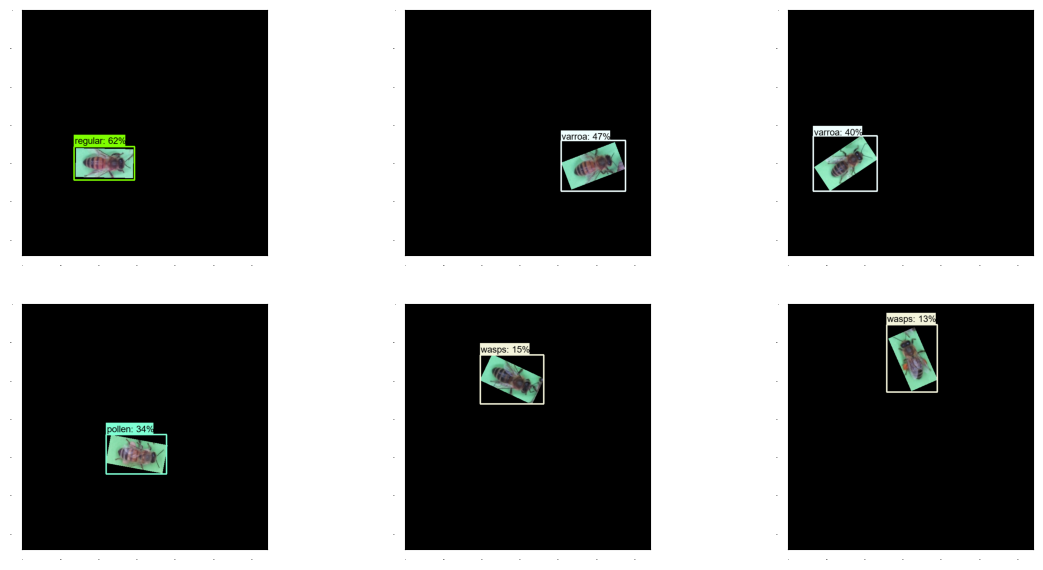

INFO:tensorflow:Assets written to: C:/Users/khard/Documents/GitHub/jupyter/PollenCounter/non_extract_sub_model\assets


INFO:tensorflow:Assets written to: C:/Users/khard/Documents/GitHub/jupyter/PollenCounter/non_extract_sub_model\assets


Done


In [14]:
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function(input_signature=[tf.TensorSpec(shape=[None,640,640,3], dtype=tf.float32)])
#@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(6):
    plt.subplot(2, 3, i + 1)
    rand_elem = random.randint(0, len(test_images_np) - idx)
    input_tensor = tf.convert_to_tensor(test_images_np[i + rand_elem], dtype=tf.float32)
    input_tensor = tf.expand_dims(input_tensor, 0)
    detections = detect(input_tensor)
    
    plot_detections(
        test_images_np[i + rand_elem],
        np.array([detections['detection_boxes'][0][i]]),
        [(detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset)[i]],
        [(detections['detection_scores'][0].numpy())[i]],
        category_index, figsize=(15, 20))
plt.show()

model_directory = 'C:/Users/khard/Documents/GitHub/jupyter/PollenCounter/'
model_name = 'non_extract_sub_model'
model_dest = os.path.join(os.sep, model_directory, model_name)

tf.saved_model.save(
    detection_model , model_dest,
    signatures={
      'detect': detect.get_concrete_function()
    })

print("Done")

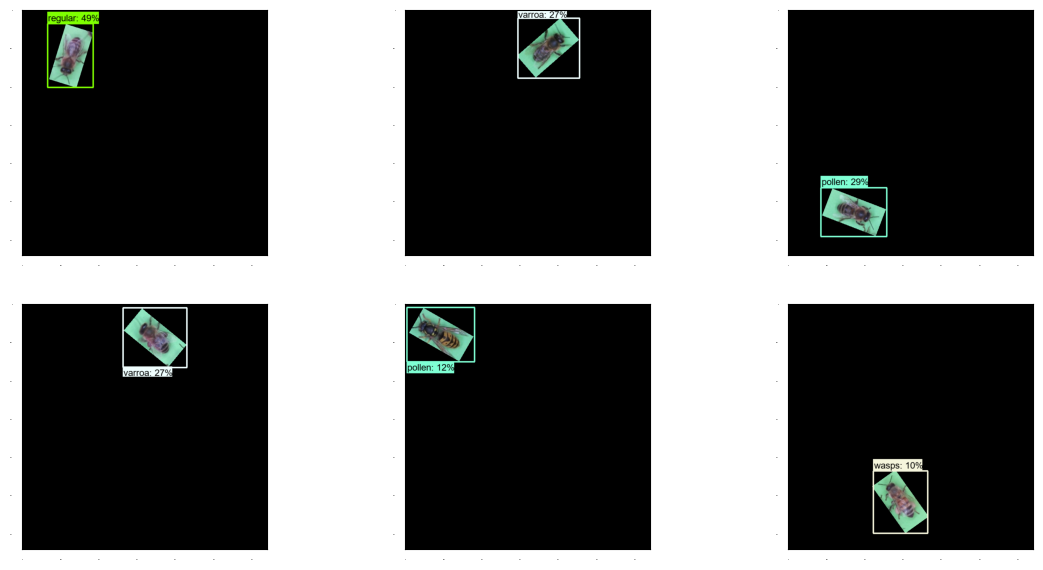

In [15]:
new_model=tf.saved_model.load(model_dest)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    rand_elem = random.randint(0, len(test_images_np) - idx)
    input_tensor = tf.convert_to_tensor(test_images_np[i + rand_elem], dtype=tf.float32)
    input_tensor = tf.expand_dims(input_tensor, 0)
    detections = new_model.signatures['detect'](input_tensor)

    plot_detections(
        test_images_np[i + rand_elem],
        np.array([detections['detection_boxes'][0][i]]),
        [(detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset)[i]],
        [(detections['detection_scores'][0].numpy())[i]],
        category_index, figsize=(15, 20))
plt.show()